In [1]:
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

### Облако слов

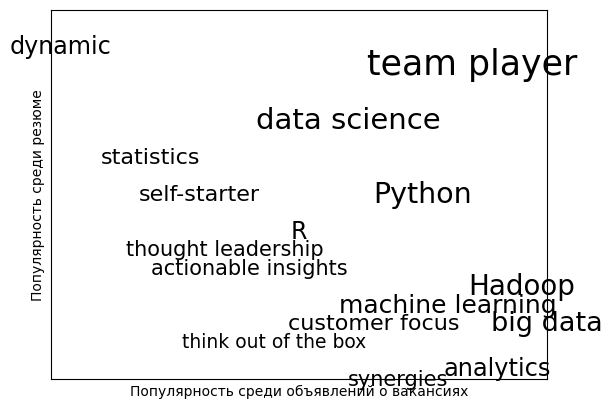

In [2]:
from matplotlib import pyplot as plt

def text_size(total: int) -> float:
        """Равняется 8, если итог равен 0, и 28, если итог равен 200"""
        return 8 + total / 200 * 20
    
for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
            ha='center', va='center',
            size=text_size(job_popularity + resume_popularity))
    plt.xlabel("Популярность среди объявлений о вакансиях")
    plt.ylabel("Популярность среди резюме")
    plt.axis([0, 100, 0, 100])
    plt.xticks([])
    plt.yticks([])
plt.show()

## N-грамные языковые модели

### Символы Юникода в нормальные апострофы

In [3]:
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

### Разбиваем текст на последовательность слов и точек

In [4]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text

soup = BeautifulSoup(html, 'html5lib')
content = soup.find("div", "postContent-content")   # Отыскать div с именем article-body
regex = r"[\w']+|[\.]"                       # Сочетает слово и точку

document = []


for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

### Биграмная модель

In [5]:
from collections import defaultdict

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

### Генерируем предложения

In [6]:
import random

def generate_using_bigrams() -> str:
    current = "."   # Означает, что следующее слово начнет предложение
    result = []
    while True:
        next_word_candidates = transitions[current]    # Биграммы (current, _)
        current = random.choice(next_word_candidates)  # Выбрать одно случайно
        result.append(current)                         # добавить в result
        if current == ".": return " ".join(result)     # если ".", то завершаем


generate_using_bigrams()


'Data is indeed the word Apple industry is all of person are the Python Elefant Weka in R is very flexible process .'

### Триграммы

In [7]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):

    if prev == ".":              # Если предыдущее "слово" было точкой,
        starts.append(current)   # то это стартовое слово

    trigram_transitions[(prev, current)].append(next)

### Генерируем предложения

In [8]:
def generate_using_trigrams() -> str:
    current = random.choice(starts)   # Выбрать случайное стартовое слово
    prev = "."                        # и предварить его символом '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)

        prev, current = current, next_word
        result.append(current)

        if current == ".":
            return " ".join(result)
        

generate_using_trigrams()

'Their business is fundamentally different from selling music sharing music or analyzing musical tastes though these can also be data products that are easily described you can start thinking about the big problem .'

## Грамматики

### Определим грамматику

In [9]:
from typing import List, Dict

# Псевдоним типов для ссылки на грамматики позже
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

### Ф-ия для выявления терминалов

In [10]:
def is_terminal(token: str) -> bool:
    return token[0] != "_"

### Список лексем в предложение

In [11]:
def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # Если это терминальная лексема, то пропустить ее
        if is_terminal(token): continue

        # В противном случае это нетерминальная лексема,
        # поэтому нам нужно случайно выбрать подстановку
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Подстановкой могла бы быть, например, "_NP _VP", поэтому нам
            # sнужно разбить ее по пробелам и присоединить к списку
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

        # Теперь вызвать expand с новым списком лексем
        return expand(grammar, tokens)

    # Если мы тут, значит, у нас были терминалы. Закончить обработку
    return tokens

### Генерируем предложения

In [12]:
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

generate_sentence(grammar)

['big', 'regression', 'about', 'linear', 'data science', 'tests']

## Генерирование выборок по Гиббсу

#### это техническое решение для извлечения выборок из многомерных распределений, когда известны лишь некоторые условные распределения

### Генерируем выборки (бросание 2-х кубиков) (x - значение первого кубика, y - сумма кубиков)

In [13]:
from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

### распределение y в зависимости от x

In [14]:
def random_y_given_x(x: int) -> int:
    """Равновероятно составляет x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

### распределение x в зависимости от y

In [15]:
def random_x_given_y(y: int) -> int:
    if y <= 7:
        # Если сумма <= 7, то первый кубик равновероятно будет
        # 1, 2, ..., (сумма - 1)
        return random.randrange(1, y)
    else:
        # Если сумма > 7, то первый кубик равновероятно будет
        # (сумма - 6), (сумма - 5), ..., 6
        return random.randrange(y - 6, 7)

#### генерирование выборок по Гиббсу работает так: мы начинаем с любых(допустимых) значений x и y и затем многократно чередуем, подставляя вместо x случайное значение, выбранное в зависимости от y, и подставляя вместо y случайное значение, выбранное в зависимости от x. После ряда итераций полученные значения x и y будут представлять выборку из безусловного совместного распределения

### Выборка по Гиббсу

In [16]:
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

### Сравнить распределения

In [17]:
def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

## Тематическое моделирование (312)

### Ф-ия, которая будет случайно выбирать индекс, основываясь на произвольном множесте весов

In [18]:
def sample_from(weights: List[float]) -> int:
    """Возвращает i с вероятностью weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # Равномерно между 0 и суммой
    for i, w in enumerate(weights):
        rnd -= w                       # Вернуть наименьший i
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd


In [19]:
from collections import Counter

# Извлечь 1000 раз и подсчитать
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190   # ~10%
assert 10 < draws[1] < 190   # ~10%
assert 650 < draws[2] < 950  # ~80%
assert draws[0] + draws[1] + draws[2] == 1000

### Документ интересов пользователей

In [20]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]


### Кол-во тематик

In [21]:
K = 4

### Сколько раз каждая тематика назначается каждому документу

In [22]:
# Список объектов Counter, один для каждой тематики
document_topic_counts = [Counter() for _ in documents]
document_topic_counts

[Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter()]

### Сколько раз каждое слово назначается каждой тематике

In [23]:
# Список объектов Counter, один для каждой тематики
topic_word_counts = [Counter() for _ in range(K)]
topic_word_counts

[Counter(), Counter(), Counter(), Counter()]

### Суммарное число слов, назначенное каждой тематике

In [24]:
# Список чисел, один для каждой тематики
topic_counts = [0 for _ in range(K)]
topic_counts

[0, 0, 0, 0]

### Суммарное число слов, содержащихся в каждом документе

In [25]:
# Список чисел, один для каждого документа
document_lengths = [len(document) for document in documents]
document_lengths

[7, 5, 6, 5, 4, 6, 4, 4, 4, 4, 3, 4, 3, 5, 3]

### Число различных слов

In [26]:
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)
W

36

### Число документов

In [27]:
D = len(documents)
D

15

### Пример

In [28]:
print(document_topic_counts[3][1])

print(topic_word_counts[2]["nlp"])

0
0


### Определяем функции условной вероятности 

In [29]:
# Вероятность тематики в зависимости от документа
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    Доля слов в документе 'd', которые назначаются
    тематике 'topic' (плюс некоторое сглаживание)
    """
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

# Вероятность слова в зависимости от тематики
def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    Доля слов, назначаемых тематике 'topic', которые 
    равны 'word' (плюс некоторое сглаживание)
    """
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

### Веса для обновления тематик

In [30]:
# Вес тематики
def topic_weight(d: int, word: str, k: int) -> float:
    """
    С учетом документа и слова в этом документе,
    вернуть вес k-й тематики
    """
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

# Выбрать новую тематику
def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

### Назначим каждому слову случайную тематику и заполним наши количественные показатели 

In [31]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

#### Далее нам нужно получить совместную выборку из тематико-словарного распределения("тематика-слово") и документно-тематического распределения ("документ-тематика")

### Используем форму генерирования выборок по Гиббсу, в которой используются ранее определенные условные вероятности

In [32]:
import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # Удалить это слово/тематику из показателя,
            # чтобы оно не влияло на веса
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # Выбрать новую тематику, основываясь на весах
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # И добавить его назад в показатель
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2483.01it/s]


In [33]:
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1


### Назначим тематические названия

In [34]:
topic_names = ["Big Data and programming languages",
               "databases",
               "Python and statistics",
               "machine learning"]

In [35]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
databases 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
databases 2
Python and statistics 2
machine learning 2

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 3
Python and statistics 2

['machine learning', 'regression', 'decision trees', 'libsvm']
Python and statistics 2
databases 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
Python and statistics 3
Big Data and programming languages 3

['statistics', 'probability', 'mathematics', 'theory']
machine learning 3
Python and statistics 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
Python and statistics 2
databases 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
databases 3
Big Data and programming languages 1

['Hadoop', 'Java', 'MapReduce', 'Big 

## Векторы слов

### задачи: 
####      1) Получить фрагмент текста
####      2) Создать набор данных, где цель состоит в том, чтобы предсказать слово с учетом близлежащих слов
####      3) Натренировать нейронную сеть хорошо справляться с этой задачей
####      4) Взять внутренние состояния натренированной нейронной сети как векторы слов

### Будем измерять "сходство", используя косинусное сходство(т.е. числом между -1 и 1), служащее мерой степени, в которой два вектора указывают в одном направлении

In [36]:
from theory.linear_algebra import dot, Vector
import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

assert cosine_similarity([1., 1, 1], [2., 2, 2]) == 1, "то же направление"
assert cosine_similarity([-1., -1], [2., 2]) == -1,    "противоположное направление"
assert cosine_similarity([1., 0], [0., 1]) == 0,       "ортогональное"

### Усвоим несколько векторов, чтобы увидеть, как это работает

In [37]:
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

In [38]:
# Составить предложение
def make_sentence() -> str:
    return " ".join([
        "The",
        random.choice(colors),
        random.choice(nouns),
        random.choice(verbs),
        random.choice(adverbs),
        random.choice(adjectives),
        "."
    ])

NUM_SENTENCES = 50

random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]
sentences

['The yellow cat is extremely hard .',
 'The yellow boat was extremely fast .',
 'The black car was quite slow .',
 'The black boat seems quite soft .',
 'The red bed seems extremely hard .',
 'The black bed was  soft .',
 'The black car seems  hard .',
 'The black boat is very slow .',
 'The  cat seems very hard .',
 'The blue car seems extremely slow .',
 'The green car is quite hard .',
 'The red bed was  slow .',
 'The blue boat seems very soft .',
 'The black car seems extremely hard .',
 'The red cat was quite soft .',
 'The green car is very soft .',
 'The yellow bed is quite fast .',
 'The red bed seems  soft .',
 'The black car is  soft .',
 'The yellow cat seems extremely slow .',
 'The blue bed was extremely fast .',
 'The green bed seems extremely slow .',
 'The  car was quite soft .',
 'The yellow bed is quite fast .',
 'The red bed is very fast .',
 'The black bed was very soft .',
 'The red bed seems very fast .',
 'The green bed was quite slow .',
 'The  bed seems  slow

### 

In [39]:
from DL import Tensor

class Vocabulary:
    def __init__(self, words: List[str] = None) -> None:
        self.w2i: Dict[str, int] = {}  # Отображение word -> word_id
        self.i2w: Dict[int, str] = {}  # Отображение word_id -> word

        for word in (words or []):     # Если слова были предоставлены,
            self.add(word)             # то добавить их

    @property
    def size(self) -> int:
        """Сколько слов в  лексиконе"""
        return len(self.w2i)

    def add(self, word: str) -> None:
        if word not in self.w2i:        # Если слово является для нас новым:
            word_id = len(self.w2i)     # то отыскать следующий id
            self.w2i[word] = word_id    # Добавить в отображение word -> word_id
            self.i2w[word_id] = word    # Добавить в отображение word_id -> word

    def get_id(self, word: str) -> int:
        """вернуть id слова (либо None)"""
        return self.w2i.get(word)

    def get_word(self, word_id: int) -> str:
        """Вернуть слово с заданным id (либо None)"""
        return self.i2w.get(word_id)

    def one_hot_encode(self, word: str) -> Tensor:
        word_id = self.get_id(word)
        assert word_id is not None, f"неизвестное слово {word}"

        return [1.0 if i == word_id else 0.0 for i in range(self.size)]

ModuleNotFoundError: No module named 'gradient_descent'

In [ ]:
vocab = Vocabulary(["a", "b", "c"])
assert vocab.size == 3              
assert vocab.get_id("b") == 1,       "b должно иметь word_id 1"
assert vocab.one_hot_encode("b") == [0, 1, 0]
assert vocab.get_id("z") is None,    "z отсутсвует в лексиконе"
assert vocab.get_word(2) == "c",     "word_id 2 должно быть c"
vocab.add("z")
assert vocab.size == 4,              "теперь в лексиконе есть 4 слова"
assert vocab.get_id("z") == 3,       "теперь z должен иметь id 3"
assert vocab.one_hot_encode("z") == [0, 0, 0, 1]

### Ф-ии для сохранения и загрузки словаря

In [ ]:
import json

def save_vocab(vocab: Vocabulary, filename: str) -> None:
    with open(filename, 'w') as f:
        json.dump(vocab.w2i, f)       # Нужно сохранить только w2i

def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        # Загрузить w2i и сегнерировать из него i2w
        vocab.w2i = json.load(f)
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}
    return vocab

##### (321) Будем использовать модель векторов слов под названием Skip-Gram, которая принимает на входе слово и генерирует вероятности слов, которые могут встретиться рядом с ним (Еще есть распросраненная модель CBOW - мешок слов)

### Создадим нейросеть 

##### В ее основе будет слой вложения, который на входе принимает идентификатор слова и возвращает вектор слова(можно использовать для этого простую просмотровую таблицу)

##### Далее передаем векторы слов в линейный слой Linear с тем же числом выходов, что и слова в нашем лексиконе. Также будем использовать ф-ию softmax для конвертации этих выходов в вероятности над близлежащими словами

##### Поскольку для тренировки модели используется градиентный спуск, нужно обновлять векторы в просмотровой таблице

In [ ]:
from typing import Iterable
from DL import Layer, Tensor, random_tensor, zeros_like

class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        # Один вектор размера embedding_dim для каждого желаемого вложения
        self.embeddings = random_tensor(num_embeddings, embedding_dim)
        self.grad = zeros_like(self.embeddings)

        # Сохранить id последнего входа
        self.last_input_id = None

    def forward(self, input_id: int) -> Tensor:
        """Просто выбрать вектор вложения, соответсвующий входному id"""
        self.input_id = input_id    # Запомнить для использования в обратном распространении

        return self.embeddings[input_id]

    # Для обратного прохождения получим градиент, соответсвующий выбранному вектору вложения, 
    # и нужно будет построить соответсвующий градиент для вложений self.embeddings, 
    # который равен нулю для каждого входного вложения, отличного от выбранного
    def backward(self, gradient: Tensor) -> None:
        # Обнулить градиент, соответсвующий последнему входу
        # Это гараздо дешевле, чем всякий раз создавать новый тензор нулей
        if self.last_input_id is not None:
            zero_row = [0 for _ in range(self.embedding_dim)]
            self.grad[self.last_input_id] = zero_row

        self.last_input_id = self.input_id
        self.grad[self.input_id] = gradient

    # Поскольку есть параметры и градиенты, нужны эти методы
    def params(self) -> Iterable[Tensor]:
        return [self.embeddings]

    def grads(self) -> Iterable[Tensor]:
        return [self.grad]

### Подкласс специально для векторов слов

##### В таком случае число вложений определяется лексиконом

In [ ]:
class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # Вызвать конструктор суперкласса
        super().__init__(vocab.size, embedding_dim)

        # И зафиксировать лексикон
        self.vocab = vocab

    # Извлечение вектора для заданного слова. Например word_vector = embedding["black"]
    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None

    # Хотелось бы, чтобы слой вложения сообщал самые близкие слова к заданному слову
    def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
        """Возвращает n ближайших слов на основе косинусного сходства"""
        vector = self[word]

        # Вычислить пары (сходство, другое_слово) и отсортировать по схожести
        # (самое схожее идет первым)
        scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
                  for other_word, i in self.vocab.w2i.items()]
        scores.sort(reverse=True)

        return scores[:n]

### Собираем тренировочные данные. Для каждого входного слова выберем два слова слева и два слова справа в качестве целевых

In [ ]:
import re
    
# Это регулярное выражение не лучшее,
# но оно справляется с нашими данными
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                        for sentence in sentences]
    
# Создать лексикон (т.е. отображение word -> word_id)
# на основе нашего текста
vocab = Vocabulary(word
                    for sentence_words in tokenized_sentences
                    for word in sentence_words)

In [ ]:
from DL import Tensor, one_hot_encode
    
inputs: List[int] = []
targets: List[Tensor] = []
    
for sentence in tokenized_sentences:
    for i, word in enumerate(sentence):          # Для каждого слова
        for j in [i - 2, i - 1, i + 1, i + 2]:   # взять близлежащие расположения,
            if 0 <= j < len(sentence):           # которые не выходят за границы,
                nearby_word = sentence[j]        # и получить эти слова
    
                # Добавить вход, т.е. исходный word_id
                inputs.append(vocab.get_id(word))
    
                # Добавить цель, т.е. близлежащее слово,
                # кодированное с одним активным состоянием
                targets.append(vocab.one_hot_encode(nearby_word))

### Модель

In [ ]:
from DL import Sequential, Linear
    
random.seed(0)
EMBEDDING_DIM = 5  # возьмем такой размер
    
# Определить слой вложений отдельно,
# чтобы можно было на него ссылаться
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)
    
model = Sequential([
    # С учетом заданного слова (как вектора идентификаторов word_id)
    # найти его вложение
    embedding,
    # И применить линейный слой для вычисления
    # балльных отметок для "близлежащих слов"
    Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size)
])

### Тренируем модель

In [ ]:
from DL import SoftmaxCrossEntropy, Momentum, GradientDescent
    
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)
    
for epoch in range(100):
    epoch_loss = 0.0
    for input, target in zip(inputs, targets):
        predicted = model.forward(input)
        epoch_loss += loss.loss(predicted, target)
        gradient = loss.gradient(predicted, target)
        model.backward(gradient)
        optimizer.step(model)
    print(epoch, epoch_loss)            # Напечатать потерю, а также
    print(embedding.closest("black"))   # несколько близлежащих слов,
    print(embedding.closest("slow"))    # чтобы увидеть, что было
    print(embedding.closest("car"))     # усвоено

0 2970.156429387063
[(1.0, 'black'), (0.7927247753692505, 'blue'), (0.5911733314896047, 'cat'), (0.5716654981660781, 'the'), (0.3026892975059721, 'car')]
[(1.0, 'slow'), (0.8936272640937163, 'green'), (0.5272141409772462, '.'), (0.35601330438834605, 'yellow'), (0.29982973123116025, 'blue')]
[(1.0, 'car'), (0.7030889033452818, 'cat'), (0.519105254858335, 'fast'), (0.42366926734379523, 'very'), (0.3848186865089064, 'quite')]
1 2865.8555108332894
[(1.0, 'black'), (0.8076054877794637, 'blue'), (0.611245900026446, 'cat'), (0.5676562111596322, 'the'), (0.3273307461476133, 'car')]
[(1.0, 'slow'), (0.8795208130766506, 'green'), (0.5675261127213351, '.'), (0.36241066630787394, 'yellow'), (0.3593451263736934, 'boat')]
[(1.0, 'car'), (0.7121322616680856, 'cat'), (0.49717481866583707, 'fast'), (0.40999217231019636, 'very'), (0.3655326707405853, 'quite')]
2 2815.0355266564657
[(1.0, 'black'), (0.8240340241906856, 'blue'), (0.6310891601317347, 'cat'), (0.5448895203899405, 'the'), (0.3541498544488745

### Разведуем наиболее похожие слова

In [ ]:
pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
        for w1 in vocab.w2i
        for w2 in vocab.w2i
        if w1 < w2]
pairs.sort(reverse=True)
print(pairs[:5])

[(0.9948304450324578, 'bed', 'cat'), (0.9920899253848233, 'seems', 'was'), (0.9883988811665566, 'bed', 'boat'), (0.9821293900663808, 'black', 'blue'), (0.9709525703302307, 'green', 'red')]


### Извлечем первые две главные компоненты и выведем на график

In [ ]:
from theory.working_with_data import transform, pca
import matplotlib.pyplot as plt
    
# Extract the first two principal components and transform the word vectors
components = pca(embedding.embeddings, 2)
transformed = transform(embedding.embeddings, components)
    
# Scatter the points (and make them white so they're "invisible")
fig, ax = plt.subplots()
ax.scatter(*zip(*transformed), marker='.', color='w')
    
# Add annotations for each word at its transformed location
for word, idx in vocab.w2i.items():
    ax.annotate(word, transformed[idx])
    
# And hide the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
    
plt.show()

ModuleNotFoundError: No module named 'probability'